<a href="https://colab.research.google.com/github/bsmrvl/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [266]:
df = df.drop('diagnosis', axis=1)
print(df.shape)
df.head()

(569, 32)


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [267]:
# Check for NaNs

print(df.shape)
df.isnull().sum()

(569, 32)


id                           0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: i

In [268]:
# The last column is obviously worthless. Let's drop that too. We'll also drop the ID column;
# we shouldn't be changing the order of our rows, so we won't need ID to make comparisons.
# (We'll keep it in the original df just in case)

df = df.drop('Unnamed: 32', axis=1)
features = df.drop('id', axis=1)
features.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [269]:
features.shape

(569, 30)

## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [270]:
# First I'm going to create a diagnosis dataframe, starting with the official 
# diagnoses and adding the ones from my models as I go.

diagnoses = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")[['diagnosis']].rename(columns={'diagnosis':'official'})
diagnoses['official'].value_counts()

B    357
M    212
Name: official, dtype: int64

In [271]:
# Perform K-Means Clustering on the Dataset

# First check the elbow.

K = range(1,11)
sum_squared_distance = []

for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(features)
  sum_squared_distance.append(kmeans.inertia_)

sum_squared_distance

[256677243.9542025,
 77943099.87829883,
 47336610.421990566,
 29226541.651979793,
 20539877.62210288,
 16558716.70201728,
 13247221.844211662,
 11181021.560506755,
 9565358.64237499,
 8565632.540349364]

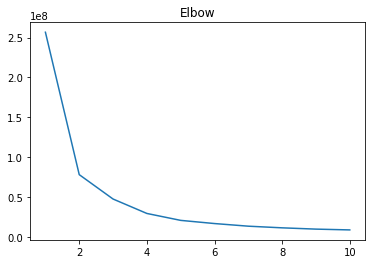

In [272]:
plt.plot(K, sum_squared_distance)

plt.title('Elbow')

plt.show()

In [273]:
# Looks like we should do k=2. This makes sense considering there are two possible
# diagnoses.

# Let's fit our k-means on the original (non-pca) data.

kmeans = KMeans(n_clusters=2)
kmeans.fit(features)

# Add these cluster groupings to our diagnoses dataframe.

diagnoses['kmeans_og_data'] = kmeans.labels_
diagnoses['kmeans_og_data'].value_counts()

1    438
0    131
Name: kmeans_og_data, dtype: int64

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [274]:
pd.crosstab(diagnoses['official'], diagnoses['kmeans_og_data'], margins=True)

kmeans_og_data,0,1,All
official,,,
B,1,356,357
M,130,82,212
All,131,438,569


In [275]:
# It appears my cluster 0 lines up with a malignant diagnosis. Cluster 1 lines up somewhat
# with a benign diagnosis, but gives a fair number of false malignants. Let's calculate the
# exact percentage my clusters got correct.


def compare_to_official(dataframe, column, malignant, benign):
  correct = []

  for index, row in dataframe.iterrows():
    if (row['official'] == 'M' and row[column] == malignant) or (row['official'] == 'B' and row[column] == benign):
      correct.append(1)
    else:
      correct.append(0)

  return correct


diagnoses['kmeans_og_data_correct'] = compare_to_official(diagnoses, column='kmeans_og_data', malignant=0, benign=1)
  
diagnoses.head()

,official,kmeans_og_data,kmeans_og_data_correct
0,M,0,1
1,M,0,1
2,M,0,1
3,M,1,0
4,M,0,1


In [276]:
cluster_accuracy = diagnoses['kmeans_og_data_correct'][diagnoses['kmeans_og_data_correct'] == 1].count() / 569
cluster_accuracy

0.8541300527240774

In [250]:
# The k-means clusters on the original (non-pca) data were about 85% accurate.

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [277]:
##### Your Code Here #####

scalar = StandardScaler()

features_Z = scalar.fit_transform(features)
features_Z

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

In [278]:
pca = PCA()
components = pca.fit_transform(features_Z)
pca.explained_variance_ratio_

array([4.42720256e-01, 1.89711820e-01, 9.39316326e-02, 6.60213492e-02,
       5.49576849e-02, 4.02452204e-02, 2.25073371e-02, 1.58872380e-02,
       1.38964937e-02, 1.16897819e-02, 9.79718988e-03, 8.70537901e-03,
       8.04524987e-03, 5.23365745e-03, 3.13783217e-03, 2.66209337e-03,
       1.97996793e-03, 1.75395945e-03, 1.64925306e-03, 1.03864675e-03,
       9.99096464e-04, 9.14646751e-04, 8.11361259e-04, 6.01833567e-04,
       5.16042379e-04, 2.72587995e-04, 2.30015463e-04, 5.29779290e-05,
       2.49601032e-05, 4.43482743e-06])

In [279]:
# Let's do some k-means on the first two components.

kmeans = KMeans(n_clusters=2)
kmeans.fit(components[:,:2])

df2 = pd.DataFrame({'component_1':components[:,0], 'component_2':components[:,1], 'cluster':kmeans.labels_})
df2

,component_1,component_2,cluster
0,9.192837,1.948583,0
1,2.387802,-3.768172,0
2,5.733896,-1.075174,0
3,7.122953,10.275589,0
4,3.935302,-1.948072,0
...,...,...,...
564,6.439315,-3.576817,0
565,3.793382,-3.584048,0
566,1.256179,-1.902297,0
567,10.374794,1.672010,0


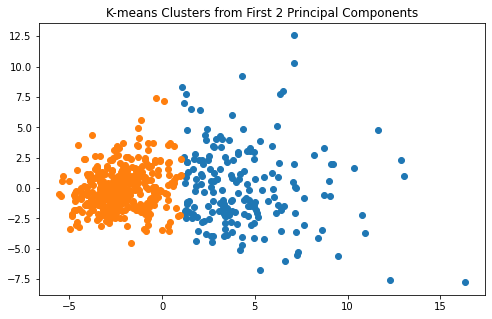

In [280]:
# Plot k-means clusters from first 2 components.

df2_c0 = df2[df2['cluster'] == 0]
df2_c1 = df2[df2['cluster'] == 1]

fig, ax = plt.subplots(figsize=[8,5])

ax.scatter(df2_c0['component_1'], df2_c0['component_2'])
ax.scatter(df2_c1['component_1'], df2_c1['component_2'])

ax.set_title('K-means Clusters from First 2 Principal Components')

plt.show()

In [281]:
diagnoses['kmeans_pc1-2'] = df2['cluster']

diagnoses.head()

,official,kmeans_og_data,kmeans_og_data_correct,kmeans_pc1-2
0,M,0,1,0
1,M,0,1,0
2,M,0,1,0
3,M,1,0,0
4,M,0,1,0


In [282]:
# Again it appears that cluster 0 corresponds with malignant diagnoses.

diagnoses['kmeans_pc1-2_correct'] = compare_to_official(diagnoses, column='kmeans_pc1-2', malignant=0, benign=1)

diagnoses.head()

,official,kmeans_og_data,kmeans_og_data_correct,kmeans_pc1-2,kmeans_pc1-2_correct
0,M,0,1,0,1
1,M,0,1,0,1
2,M,0,1,0,1
3,M,1,0,0,1
4,M,0,1,0,1


In [283]:
cluster_accuracy = diagnoses['kmeans_pc1-2_correct'][diagnoses['kmeans_pc1-2_correct'] == 1].count() / 569
cluster_accuracy

0.9068541300527241

In [258]:
# Wow! With just 2 principal components we increased our diagnosis accuracy by 5%.

In [284]:
# Now let's create our scree plot. (Most of this code is what I worked on yesterday)

cum_variance_percent = np.cumsum(pca.explained_variance_ratio_)*100

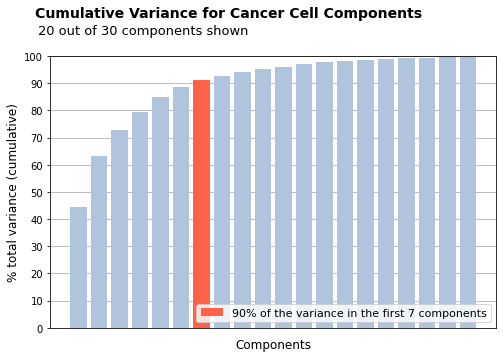

In [285]:
fig, ax = plt.subplots(figsize=[8,5])

fig.set_facecolor('white')

ax.set_xlabel('Components', fontsize=12, labelpad=10)
ax.set_xticks([])
ax.set_ylabel('% total variance (cumulative)', fontsize=12)
ax.set_ylim([0,100])
ax.set_yticks([t*10 for t in range(11)])


#### Try changing these values! Control how many components are shown in the graph,
#### and what threshold percentage we want to check.

show = 20              
percent_thresh = 90

####
####

# Main bars
rects = ax.bar(x=[num for num in range(show)], height=cum_variance_percent[:show], color='lightsteelblue', zorder=100)

# Function to determine the point at which the threshold is passed
def percent_of_variance(rects, percent):
  for i in range(len(rects)):
    if rects[i].get_height() > percent:
      return i

# Run function and print tomato bar.
first = percent_of_variance(rects, percent_thresh)
thresh = ax.bar(x=first, height=cum_variance_percent[first], color='tomato', zorder=200)

ax.set_title('Cumulative Variance for Cancer Cell Components', fontsize=14, fontweight='bold', x=.4, y=1.12)
ax.text(s=str(show) + ' out of 30 components shown', x=-2, y=108, fontsize=13)

ax.grid(b=True, axis='y')
ax.legend([thresh],[str(percent_thresh) + '% of the variance in the first ' + str(first+1) + ' components'], loc='lower right', fontsize=11).set_zorder(300)

plt.show()

In [286]:
# So we should use 7 components.

kmeans = KMeans(n_clusters=2)
kmeans.fit(components[:,:7])

diagnoses['kmeans_pc1-7'] = kmeans.labels_
diagnoses.head()

,official,kmeans_og_data,kmeans_og_data_correct,kmeans_pc1-2,kmeans_pc1-2_correct,kmeans_pc1-7
0,M,0,1,0,1,1
1,M,0,1,0,1,1
2,M,0,1,0,1,1
3,M,1,0,0,1,1
4,M,0,1,0,1,1


In [287]:
# Looks like this time the cluster numbers are flipped (cluster 1 corresponds with malignant).
# Let's apply that in our comparison function.

diagnoses['kmeans_pc1-7_correct'] = compare_to_official(diagnoses, column='kmeans_pc1-7',  malignant=1, benign=0)
  
diagnoses.head()

,official,kmeans_og_data,kmeans_og_data_correct,kmeans_pc1-2,kmeans_pc1-2_correct,kmeans_pc1-7,kmeans_pc1-7_correct
0,M,0,1,0,1,1,1
1,M,0,1,0,1,1,1
2,M,0,1,0,1,1,1
3,M,1,0,0,1,1,1
4,M,0,1,0,1,1,1


In [288]:
cluster_accuracy = diagnoses['kmeans_pc1-7_correct'][diagnoses['kmeans_pc1-7_correct'] == 1].count() / 569
cluster_accuracy

0.9103690685413005

In [264]:
# Using 7 principal components rather than 2, we only increased our accuracy by about
# 1 percent (almost). 

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [ ]:
# See above.

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project